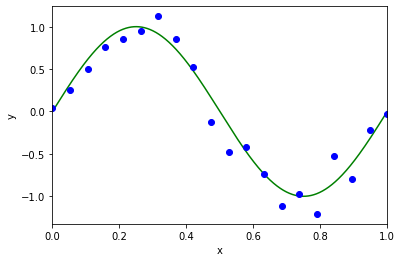

In [192]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import random
np.random.seed(19)
N  = 20
beta = 25
alpha = 2
cant_functions = 10
prior_mean = [0]*cant_functions
prior_cov = 1/alpha * np.eye(cant_functions)
mean_c = prior_mean
cov_c = prior_cov

obs_x = np.linspace(0,1,N)
obs_y = np.sin(np.pi*2*obs_x)
obs_y = np.random.normal(0,0.2,N) + obs_y

# 1000 linearly spaced numbers
plot_x = np.linspace(0,1,1000)

# the function, which is y = sin(2*pi*x) here
plot_y = np.sin(np.pi*2*plot_x)

# plot the function
plt.plot(plot_x,plot_y, 'g')
plt.xlim(0,1)
#Create and Plot observations
plt.plot(obs_x,obs_y,'bo')

# show the plot

plt.xlabel("x")
plt.ylabel("y")
plt.show()


In [193]:
def prepare_matrix(x,m):
    A = np.zeros(shape=(len(x),m))
    for i in range(0,len(x)):
        for j in range(0,m):
            A[i][j]= np.exp(-((x[i]-j/m)**2)/(2*(0.1**2)))
        A[0][j] = 1    
    return A
def plot_fun(x,coeff,m):
    res = []
    for i in range(len(x)):
        val = 0
        for j in range(0,m):
            val+= np.exp(-((x[i]-j/m)**2)/(2*(0.1**2)))*coeff[j]
        res.append(val)
    return res   

def learn(xx, yy,cov_inv_ant,mean_ant):
    
    cov_inv = cov_inv_ant + beta * np.outer(xx, xx)
    
    cov = np.linalg.inv(cov_inv)

    mean = cov @ (cov_inv_ant @ mean_ant + beta * yy * xx)
    
    return cov_inv, mean

def prediction_mean_std(X,cov,mean):
        
        no_samples = len(X)
       
        prediction = []
        for i in range(0,len(X)):
            x =  prepare_matrix([X[i]],cant_functions)
            predictive_std = np.sqrt(1/beta + x.dot(cov.dot(x.T)))
            predictive_mean = np.array(mean).dot(x.T)
            prediction.append((predictive_mean, predictive_std))
            
            
        return prediction


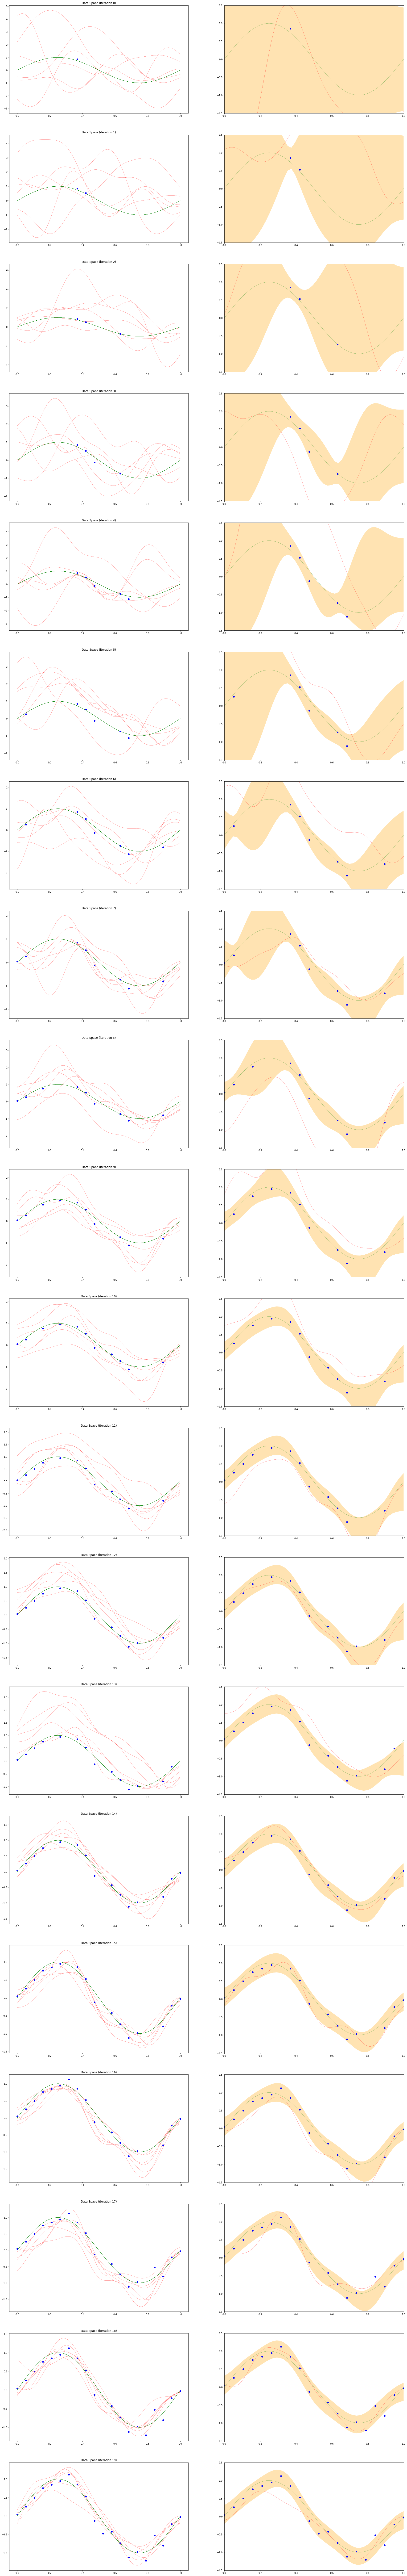

In [194]:
n_samples_data_space = 6
n_samples = 20
x_tot = []
y_tot = []
fig, axs = plt.subplots(n_samples, 2, figsize=(30, 200))
c = list(zip(obs_x, obs_y))

random.shuffle(c)

obs_x, obs_y = zip(*c)
stdevs = 1

for i in range(0,len(obs_x)):
    x_tot.append(obs_x[i])
    y_tot.append(obs_y[i])
    
    t = np.linspace(0, 1, 100)
    h = np.linspace(0, 1, 100)
    w_0, w_1 = np.meshgrid(t, h)
    cov = np.linalg.inv(cov_c)
   
    samples_data_space = stats.multivariate_normal(mean=mean_c,cov=cov).rvs(n_samples_data_space)
    if n_samples_data_space == 1:
        samples_data_space = [samples_data_space]
    mat = prepare_matrix([obs_x[i]],cant_functions)
    x_predictions = np.linspace(-1, 1, 100)
    predictions = prediction_mean_std(x_predictions,cov,mean_c) 
    cov_c, mean_c = learn(mat[0],obs_y[i],cov_c,mean_c)
    x_data_space = np.linspace(0, 1, 1000)
    
   
    y_upper=[]
    y_lower=[]
    for p in predictions:
        y_upper.append((p[0] + stdevs * p[1])[0][0])
        
        y_lower.append((p[0] - stdevs * p[1])[0][0])
    
    y_upper = np.array(y_upper)
    y_lower = np.array(y_lower)
    for s in samples_data_space:
        y_fit_regularized = plot_fun(x_data_space,s,cant_functions)
        axs[i, 0].plot(plot_x,plot_y, 'g', linewidth=0.35)  
        axs[i, 0].plot(x_data_space,y_fit_regularized, 'r', linewidth=0.35)
    axs[i, 1].plot(plot_x,plot_y, 'g', linewidth=0.35)  
    axs[i, 1].plot(x_data_space,y_fit_regularized, 'r', linewidth=0.35)    
    axs[i, 1].fill_between(x_predictions, y_upper, y_lower, where=y_upper >= y_lower, facecolor='orange', alpha=0.3)
    axs[i, 1].set_xlim(0,1)
    axs[i, 1].set_ylim(-1.5,1.5)
    axs[i, 0].set_title('Data Space (iteration {})'.format(i))
    axs[i, 0].plot(x_tot,y_tot,'bo')
    axs[i, 1].plot(x_tot,y_tot,'bo')
    
    